# 5 - SciPy

**Summary**
> * Evaluating functions
>> * Root finding
>> * Finding the minimum/maximum


> * Numerical integration
>> * Single integrals
>> * Multiple integrals
>> * Ordinary Differential Equation integrations

> * Solving Ordinary Differential Equations (ODEs)

> * Sklearn

> * Exercises



SciPy tutorials: https://docs.scipy.org/doc/scipy/tutorial/index.html

## Evaluating functions

### Root finding


Often you will want to examine a function numerically instead of through analytic means. For example, say we want to find the root of the following function

$f(x) = x^{3} + x -1$


We can do this in pure Python using Newton's method. Here we iteratively update the variable $x$ over $n$ steps as follows


$ x_{n+1} = x_{n} - \frac{f(x_{n})}{f^{'}(x_{n})} $

where we attempt to minimize the residual



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize


def newton_algorithm(x0, n_iter, f, dfdx):
  x=x0
  for i in range(n_iter):

    x = x-f(x)/dfdx(x)

  residual = np.abs(f(x))
  return x, residual



def f1(x):
  return x**3 + x - 1

def df1dx(x):
 return 3*(x**2) + 1


solution, residual = newton_algorithm(0.001, 100, f1, df1dx)

print("Root = %.2f" % solution)


Root = 0.68


Looks pretty good! We could have also done this using SciPy, which is likely how you find roots in difficult real-world problems.

In [ ]:
optimize.root(f1, x0=0.001)


 message: The solution converged.
 success: True
  status: 1
     fun: [-1.110e-16]
       x: [ 6.823e-01]
    nfev: 10
    fjac: [[-1.000e+00]]
       r: [-2.397e+00]
     qtf: [ 1.322e-10]

### Finding the minimum/maximum

One of the things we often want to identify is the minima and maxima of a function. As an example, we will look at the Lennard-Jones potential function.

$U(r) = 4 \epsilon  \left [  \left (  \frac{\sigma}{r}^{12} - \frac{\sigma}{r}^{6}  \right ) \right ] $


Let's see if there's a minima of the plot below

Text(0, 0.5, 'Potential energy')

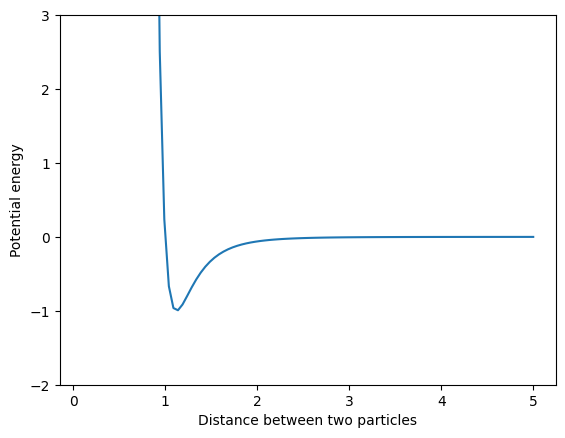

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sigma=1
epsilon=1
r_range = np.linspace(0.1,5, 100)

def U(r):

  return 4*epsilon*( (sigma/r)**12 - (sigma/r)**6 )

U_to_plot = [U(r_i) for r_i in r_range]

plt.plot(r_range, U_to_plot)
plt.ylim((-2,3))
plt.xlabel('Distance between two particles')  # x label
plt.ylabel('Potential energy')  # y label

It looks like there is one. Let's try to find the negative through numerical means. We can use Newton's algorithm again to answer this question. However, because the derivative is zero at a minimum/maximum, the local minima and maxima can be found by applying Newton's method to the derivative.

Our iterative function is now

$ x_{n+1} = x_{n} - \frac{f^{'}(x_{n})}{f^{''}(x_{n})} $

We can then take the first and second derivative of the Lennard-Jones potential.

$ U'(x) = 4 \epsilon  \left [  -12 \sigma^{12} r^{-13}  + 6 \sigma^{6} r^{-7} \right ]
\\
U''(x) = 4 \epsilon  \left [  156 \sigma^{12} r^{-14}  - 42 \sigma^{6} r^{-8} \right ]
$



In [ ]:
def dUdr(r):
  return 4*epsilon*(-12*(sigma**12)*(r**-13) + 6*(sigma**6)*(r**-7)  )

def d2Udr2(r):
  return 4*epsilon*(156*(sigma**12)*(r**-14) + 42*(sigma**6)*(r**-8)  )

solution, residual = newton_algorithm(0.2, 100, dUdr, d2Udr2)

print("r_min = %.2f" % solution)

print("U(r_min) = %.2f" % U(solution))

1.1224620483091419
r_min = 1.12
U(r_min) = -1.00


By taking the derivative of $U$ and setting it to zero we obtain the expression $r^{*} = 2^{-6}\sigma$. By taking the second derivative of $U$ and plugging in $r^{*}$ we obtain a positive value, meaining that $r^{*}$ is the minimum and $U(r^{*}) = -\epsilon = -1$. So everything checks out.

On your own

In reality you will often find minima using Python packages. We can use SciPy to find the minimum of the function, obtaining a value similar to the one we obtained above. Here we have used the L-BFGS-B algorithm instead of the Newton method.

In [ ]:
optimize.minimize(U, x0=0.1, method="L-BFGS-B")

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -0.9999999999999993
        x: [ 1.122e+00]
      nit: 7
      jac: [ 1.110e-08]
     nfev: 50
     njev: 25
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

Similar analyses can be performed to find the maximum.

## Numerical Integration

You may often encounter a function that cannot be integrated analytically or is very difficult to integrate. In this scenario, it is useful to turn to numerical integration methods.

### Single integration

First, we will integrate a function of a single variable $x$. Consider the following integral

$f(x)= \int^{1}_{0} \mathrm{exp[-x^{2}]}\,  dx$


We'll be using the trapezoidal rule for definite integrals, where we approximate the integral as

$\int^{b}_{a} f(x)  dx \approx  \frac{(b-a)}{2} * (f(b) + f(a))$

which approximates the region under $f(x)$ as a trapezoid. Similar to the root-finding algorithm, our approximations are better if we partition the integration interval into $N$ subintervals, apply the trapezoidal rule to each subinterval, and sum the results.

$\int^{b}_{a} f(x)  dx  \approx \sum_{n=1}^{N} \frac{f(x_{n-1}) + f(x_{n})}{2} \Delta x_{n} $

where $\Delta x_{n} = x_{n} - x_{n-1}$


We can perform this integration approximation numerically using only a few lines of Python.


In [ ]:
def trapizoidal_integration(f, a, b, N):

     h = (b-a)/N # trapezium height
     Xs = np.linspace(a, b, N+1) # make array of inpus (x-values)
     Ys = f(Xs) # evaluate function
     return (h/2) * (Ys[0] + Ys[-1] + 2*np.sum(Ys[1:-1]))


f = lambda x:np.exp(-x**2)

''' the lambda construction produces exactly the same as below!
def f(x):
  return np.exp(-x**2)
'''

result = trapizoidal_integration(f, 0, 1, 100)

print('result: {}'.format(result))

result: 0.7468180014679701




However it can be inconveinant to write your own integration code. Fortunately SciPy has a number of routines for performing numerical integration. Most of them are found in the same scipy.integrate library.  We will use the quad function, short for quadrature, the workhorse of SciPy’s integration functions for performing single definite integrals of a function $f(x)$.



In [ ]:
import scipy.integrate

# integrates f between 0 and 1
result, error_estimate = scipy.integrate.quad(f, 0, 1)
print('result: {}, error estimate: {}'.format(result, error_estimate))

result: 0.7468241328124271, error estimate: 8.291413475940725e-15


We have used the function lambda as short for a function definition. In this case, it is functionally identical to using def. The quad function returns the two values, in which the first number is the value of integral and the second value is the estimate of the absolute error in the value of integral. As you can see the error due to numerical optimization is much smaller than the estimated value, suggesting that the numerical optimization procedure is accurate.



### Multiple integration

Doing double integration is handled by the function dblquad, whereas triple integration is handled by tplquad. N-fold integration can be handled by nquad.
The limits of all inner integrals can be defined as functions. That is, we integrate with $a < x < b$, and at each $x$ we integrate from $g(x) < y < h(x)$.

We'll examine the following integral.


$f(x,y) = \int^{0.5}_{0} dx \int^{h(x)}_{0} dy \, 16 \,x \, y $

$h(x)= \sqrt{1-4\,x^2}$



In [ ]:
from math import sqrt

f = lambda x, y : 16*x*y
g = lambda x : 0
h = lambda x : sqrt(1-4*x**2)

result, error_estimate = scipy.integrate.dblquad(f, 0, 0.5, g, h)
print('result: {}, error estimate: {}'.format(result, error_estimate))

## Solving Ordinary Differential Equations

In mathematics, an ordinary differential equation (ODE) is a differential equation containing one or more functions of one independent variable and the derivatives of those functions (cit. Wikipedia).
Most of the time, these means an equation of functions of time.

The ODEint method of scipy solves one (or possibly a system of) ODE, i.e. gives the trajectory in time given a starting condition.

Let us integrate the Van der Pol oscillator, which has a function for the position of the pendulum $y$ as:

$ \frac{d^{2}y}{dt^{2}} - \mu (1-y^{2}) \frac{dy}{dt} + y=0$

This is a damped, nonlinear oscillator, parametrized by $\mu$ (the largest the $\mu$, the more non linear and damped it is).
It can be rewritten as a system of eqs:

$
\frac{dy_1}{dt} = \mu (y_1-\frac{1}{3}y_1^{3}-y_2)\\
\frac{dy_2}{dt}= \frac{1}{\mu}y_1
$

Where now $y = (y_1, y_2)$. (The original position is now $y_1$.)

In [ ]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint


# Define the function that calculates the derivative dy/dt
# Note that the first variables MUST be y and t, even if t is not used.
def van_der_pol_pend(y, t, mu):
  x1, x2 = y
  dydt = [ mu * (x1 - 1/3 * x1**3 - x2), 1/mu * x1]
  return dydt

# initial position
y0 = [12, 0.4]

# time spatiation of the output
t = np.linspace(0,100, 1000)

# value of mu
mu = 6

# Call the solver, giving it the function (van_der_pol_pend), the initial condition (y0),
# the time steps for which you want output (t) and the extra arguments for the function (mu)
sol = odeint(van_der_pol_pend, y0, t, args=(mu,))


Semi-exercise:
Now that you have the solution as a list of $[y_1(t), y_2(t)]$, plot them!
Plot them as a function of time, and as points in a 2D space. What can you see?

# Sklearn (Just for your information)

A library focused on Machine Learning techniques, such as:
> * Clustering
> * Classification
> * Regression

SkLearn tutorials: https://scikit-learn.org/stable/getting_started.html

#Exercise

1. Autoregulatory gene networks

A simple model of a gene network with regulatory feedback occurs when a gene is regulated by its product. This is known as autoregulation. This process can be modeled as follows, where $a$ represents mRNA concentration and $x$ represents protein concentration

One classic model of population dynamics is the Lotka-Volterra (or prey-predator) model. It models the interaction of two populations ($y_1$, the preys and $y_2$, the predators). The model is very simple, but the results - as you will see in other courses - are still quite interesting.

$$
d a/ d t = \kappa g(x) - \gamma a \\
d x / d t = \kappa_{p} a - \gamma_{p}x
$$

The four parameters represent:
- $\kappa$ = transcription rate
- $\gamma$ = transcript degredation rate
- $\kappa_{p}$ = translation rate
- $\gamma_{p}$ = protein degredation rate

and $g(x)$ is the nonlinear feedback of the protein on the transcription of mRNA. This function is often modeled as a Hill function, either as an activator (+) or a repressor (-)

$$
g_{+}(x) = 1 + \sigma  \frac{x^{2}}{K^{2} + x^{2}}  \\
g_{-}(x) = \sigma +  \frac{K^{2}}{K^{2} + x^{2}}
$$


where $\sigma$ represents the asymptotic rate of production at large protein concentrations and $K^{2}$ is the dissociation constant.


Solve the system of ODEs in time, plotting the curve of mRNA and protein as functiond of time. Try to plot different curves for $g_{+}(x)$ and $g_{-}(x)$ for the same parameters and describe how they differ.



2. "Manual integration". The simplest method for integrating a function between $a$ and $b$ is to divide the segment in $N$ parts and calculate the function at each point.

$$
\int_a^b dx f(x) \approx \sum_i^N f(x_i) (b-a)/N
$$

Using numpy arrays recreate
$f(x)= \int^{1}_{0} \mathrm{exp[-x^{2}]}\,  dx$. Using different values of $N$ and plotting the error, can you estimate what $N$ you need to obtain an error of order $10^{-14}$

3. Calculate $\pi$ using double integration.
(Hint, the area of a quarter of a circle is $\pi\, r^2 / 4$. How can you construct the boundaries of the integration?).